In [1]:
#import necessary libraries

import pandas as pd
import numpy as np
import string
import re
from matplotlib import pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk import FreqDist, word_tokenize
from nltk.tokenize import TweetTokenizer
from nltk.stem import WordNetLemmatizer 
from wordcloud import WordCloud, STOPWORDS
import re,string
import unidecode
import html


from nltk.collocations import *
bigram_measures = nltk.collocations.BigramAssocMeasures()
trigram_measures = nltk.collocations.TrigramAssocMeasures()
fourgram_measures = nltk.collocations.QuadgramAssocMeasures()

## Overview

Process twitter text data to gain insights on a brand and associated products. Create a machine learning sentiment classifier in order to predict sentiment in never before seen tweets. Create word frequency distributions, wordclouds, bigrams, and quadgrams to easily assess actionable insight to address concerns for the brand and it's product line.

## Business Problem

A growing company with an established social media presence wants to explore options for generating actionable insights from twitter text data in a more efficient way. They have a new product releasing this year and are interested in what their customers feel about their products. 

The company wants a proof of concept for a machine learning solution to this problem. Why would it be worth the time and resources? How can you easily gain actionable insight from a large collection of tweets? Can we trust the model to make accurate predictions? 


## The Data

Apple hosted an [SXSW](https://www.sxsw.com/) event in 2011 that took advantage of their release party to  crowdsource some data labeling and boost their social media traffic for the event. 
 

Using this data, sourced from [CrowdFlower](https://data.world/crowdflower/brands-and-product-emotions), as well as some data from an additional [Apple Twitter Sentiment Dataset](https://data.world/crowdflower/apple-twitter-sentiment) also made available from CrowdFlower and data.world but cleaned and processed and made available on [kaggle](https://www.kaggle.com/seriousran/appletwittersentimenttexts) by author Chanran Kim, a machine learning classifier will be created in order to predict for sentiment contained within a tweet and show how it could be used in tandem with some NLP techniques to extract actionable insights from cluttered tweet data in a manageable way. 


### Function Definition

In [2]:
#force lowercase of text series
def lower_case_text(text_series):
    text_series = text_series.apply(lambda x: str.lower(x))
    return text_series


#strip text of any hyperlinks
def strip_links(text):
    link_regex = re.compile('((https?):((\/\/)|(\\\\))+([\w\d:#@%\/;$()~_?\+-=\\\.&](#!)?)*)|{link}/gm')
    links = re.findall(link_regex, text)
    for link in links:
        text = text.replace(link[0], ', ')    
    return text

#strip text of '@' and '#' entitities
def strip_all_entities(text):
    entity_prefixes = ['@','#']
    for separator in  string.punctuation:
        if separator not in entity_prefixes:
            text = text.replace(separator,' ')
    words = []
    for word in text.split():
        word = word.strip()
        if word:
            if word[0] not in entity_prefixes:
                words.append(word)
    return ' '.join(words)


#tokenize text and remove stopwords
def process_text(text):
    tokenizer = TweetTokenizer()
    
    stopwords_list = stopwords.words('english') + list(string.punctuation)
    stopwords_list += ["''", '""', '...', '``']
    my_stop = ["#sxsw",
               "sxsw",
               "sxswi",
               "#sxswi's",
               "#sxswi",
               "southbysouthwest",
               "rt",
               "tweet",
               "tweet's",
               "twitter",
               "austin",
               "#austin",
               "link",
               "1/2",
               "southby",
               "south",
               "texas",
               "@mention",
               "ï",
               "ï",
               "½ï",
               "¿",
               "½",
               "link", 
               "via", 
               "mention",
               "quot",
               "amp",
               "austin",
               "march"
              ]
    

    brand_stop = ["apple",
                  "@apple",
                  "@apple"
                  "apple",
                  "#apple",
                  "google",
                  "downtown" 
                 ]

    stopwords_list +=  my_stop 
    stopwords_list +=  brand_stop 
    
    tokens = tokenizer.tokenize(text)
    stopwords_removed = [token for token in tokens if token not in stopwords_list]
    return stopwords_removed
    

#concact processed text data
def concat_text(processed_text):
    text_concat = []
    for text in processed_text:
        text_concat += text
    return text_concat


#use regex to find Brand/company 
#mentioned in tweet
def fill_brand_values(df):

    apple_regex_pattern = r'/ipad\s*\d?\s*app|(?i)ipads?\s?\d?|(?i)iphone\s*\d?\s*app|(?i)iphones?\d?|apple|appl|AAPL/gm'
    google_regex_patter = r'/(?i)android\s*app|(?i)androids?|(?i)google/gm'
    

    df.loc[df['tweet'].str.contains(apple_regex_pattern),'brand_or_product'] = 'Apple'
    df.loc[df['tweet'].str.contains(google_regex_patter),'brand_or_product'] = 'Google'

    df.rename({'brand_or_product': 'brand'}, axis=1, inplace=True)

    df['brand'].replace({'Other Google product or service': 'Google',
                                'iPad or iPhone App': 'Apple',
                                'Other Apple product or service': 'Apple',
                                'Android App': 'Google',
                                'Android': 'Google'
                         }, 
                         inplace=True     
                        )
    return df

#tokenize series
def series_to_tokens(processed_series):
    tokenizer = TweetTokenizer()
    string = " ".join(processed_series)
    tokens = tokenizer.tokenize(string)
    return tokens

#master cleaning function
def Master_Pre_Vectorization(text_series):
    text_series = lower_case_text(text_series)
    text_series = text_series.apply(strip_links).apply(strip_all_entities)
    text_series = text_series.apply(unidecode.unidecode).apply(html.unescape)
    text_series =text_series.apply(process_text)
    lemmatizer = WordNetLemmatizer()
    text_series = text_series.apply(lambda x: [lemmatizer.lemmatize(word) for word in x])
    return text_series.str.join(' ').copy()


#### About main dataset

The dataset was made available by [CrowdFlower](https://data.world/crowdflower/brands-and-product-emotions).

Participants evaluated tweets about multiple brands and products. The 2011 [SXSW](https://www.sxsw.com/) crowd was asked if the tweet expressed positive, negative, or no emotion towards a brand and/or product. If some emotion was expressed they were also asked to say which brand or product was the target of that emotion. The dataset was made available by [CrowdFlower](https://data.world/crowdflower/brands-and-product-emotions).

It contains over 9000 tweets labeled in the manner expressed above.

In [3]:
#import data from CrowdFlower
df1 = pd.read_csv('data/judge_1377884607_tweet_product_company.csv',
                  encoding='latin-1')

display(df1.head())
display(df1.info())

#rename column names for ease of use
#and understanding
df1.columns = ['tweet', 'brand_or_product', 'emotion']

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8721 entries, 0 to 8720
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          8720 non-null   object
 1   emotion_in_tweet_is_directed_at                     3169 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  8721 non-null   object
dtypes: object(3)
memory usage: 204.5+ KB


None

In [4]:
display(df1.isna().sum())

#inspect single NAN tweet
#drop after inspection
display(df1[df1['tweet'].isna()])
df1 = df1[df1['tweet'].isna() == False]
df1.isna().sum()
# replace all null values for brand
#with 'unknown'
df1['brand_or_product'].fillna('unknown', inplace=True)
display(df1.isna().sum())

tweet                  1
brand_or_product    5552
emotion                0
dtype: int64

,tweet,brand_or_product,emotion
6,NaN,NaN,No emotion toward brand or product


tweet               0
brand_or_product    0
emotion             0
dtype: int64

In [5]:
display(df1['emotion'].value_counts())

#remap emotions
#to create binary target
emotion_remapper = {'No emotion toward brand or product': 'neutral',
                    'Positive emotion': 'positive', 
                    'Negative emotion': 'negative',
                    "I can't tell": 'unknown'}

df1['emotion'] = df1['emotion'].map(emotion_remapper)

display(df1['emotion'].value_counts())

df1 = df1[(df1['emotion'] != 'unknown') & (df1['emotion'] != 'neutral')].copy()

df1['emotion'].value_counts()

No emotion toward brand or product    5155
Positive emotion                      2869
Negative emotion                       545
I can't tell                           151
Name: emotion, dtype: int64

neutral     5155
positive    2869
negative     545
unknown      151
Name: emotion, dtype: int64

positive    2869
negative     545
Name: emotion, dtype: int64

Looking at the normalized value counts below and the bar chart below, we can see that there is a pretty severe class imbalance, biased towards positive tweets. As Apple will likely be interested in addressing problems highlighted in negative tweets, this imbalance will play an important role in deciding how to model the data.

Luckily, there was more data readily available to import from kaggle that was originally sourced from CrowdFlower as well.

[Another Apple Twitter Sentiment Dataset](https://data.world/crowdflower/apple-twitter-sentiment) was made available from CrowdFlower. 

[The same dataset but cleaned and processed](https://datasetsearch.research.google.com/search?query=twitter%20sentiment%20apple&docid=L2cvMTFqOWJiNTVyNg%3D%3D) was made available on kaggle by author Chanran Kim. 

I decided to extract the negative tweets from this dataset to add to my current data to help to somewhat correct the imbalance in the data.

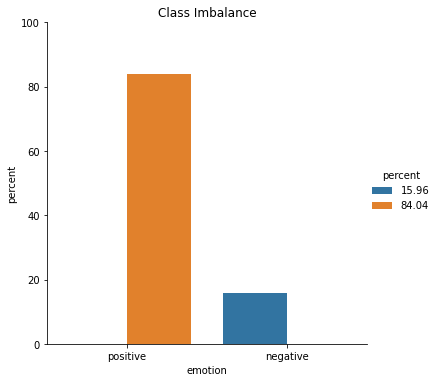

In [6]:
#create plot in order to
#visualize class imbalance


df_plot = df1['emotion'].value_counts(normalize=True)
df_plot = round(df_plot.mul(100), 2)
df_plot = df_plot.rename('percent').reset_index()


df_plot = df1['emotion'].value_counts(normalize=True)
df_plot = round(df_plot.mul(100), 2)
df_plot = df_plot.rename('percent').reset_index()

g = sns.catplot(x='index',
                y='percent',
                hue='percent',
                kind='bar',
            
                data=df_plot)
g.ax.set_ylim(0,100)
g.ax.set_title('Class Imbalance')
g.ax.set_xlabel('emotion');

In [7]:
# create numerical target 
target_mapper = {'negative': 1,
                 'positive': 0
                 }
df1['target'] = df1['emotion'].replace(target_mapper)
df1['target'].value_counts()

#I chose positive tweets to have a value of 1
#as it is the more interesting emotion
#to gain actionable insight from

0    2869
1     545
Name: target, dtype: int64

In [8]:
#import data from cleaned dataset provided on kaggle.com
#original data sourced from CrowdFlower
df_extra = pd.read_csv('data/apple-twitter-sentiment-texts.csv')
display(df_extra.head())
df_extra.isna().sum()

,text,sentiment
0,Wow. Yall needa step it up @Apple RT @heynyla:...,-1
1,What Happened To Apple Inc? http://t.co/FJEX...,0
2,Thank u @apple I can now compile all of the pi...,1
3,The oddly uplifting story of the Apple co-foun...,0
4,@apple can i exchange my iphone for a differen...,0


text         0
sentiment    0
dtype: int64

In [9]:
#keep only negative sentiment tweets
df_extra = df_extra[df_extra['sentiment'] == -1]
display(df_extra.sentiment.value_counts())
#create emotion column
df_extra['emotion'] = df_extra['sentiment'].replace({-1: 'negative'})
display(df_extra['emotion'].value_counts())
#create target column
df_extra['target'] = df_extra['emotion'].replace({'negative': 1})
df_extra['target'].value_counts()

-1    686
Name: sentiment, dtype: int64

negative    686
Name: emotion, dtype: int64

1    686
Name: target, dtype: int64

In [10]:
#prepare new data add to DataFrame
df_extra.reset_index(drop=True, inplace=True)
df_extra.drop(columns=['sentiment'], axis=1, inplace=True)
df_extra.columns = ['tweet', 'emotion', 'target']
display(df_extra.head())
display(df1.head())

#join new data
df = pd.concat([df1, df_extra])
df['brand_or_product'].fillna('unknown', inplace=True)

df['brand_or_product'].value_counts()

,tweet,emotion,target
0,Wow. Yall needa step it up @Apple RT @heynyla:...,negative,1
1,RT @JPDesloges: Apple Acted Unfairly In Suppre...,negative,1
2,Apple Inc. Deleted Songs From Rival Services F...,negative,1
3,Happy Monday! My camera on my fancy @Apple #iP...,negative,1
4,Facebook CEO Mark Zuckerberg criticizes Apple ...,negative,1


,tweet,brand_or_product,emotion,target
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,negative,1
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,positive,0
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,positive,0
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,negative,1
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,positive,0


unknown                            1027
iPad                                884
Apple                               618
iPad or iPhone App                  441
Google                              397
iPhone                              278
Other Google product or service     272
Android App                          77
Android                              73
Other Apple product or service       33
Name: brand_or_product, dtype: int64

#### Visualize New Class Imbalance

As you can see, the data is still imbalanaced but there has been a major improvement. The data is now ready to be exported for modeling. 

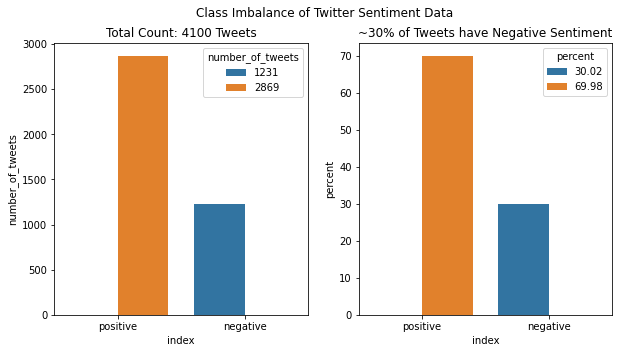

In [11]:
df_plot2 = df['emotion'].value_counts(normalize=True)
df_plot2 = round(df_plot2.mul(100), 2)
df_plot2 = df_plot2.rename('percent').reset_index()
df_plot3 = df['emotion'].value_counts()
df_plot3 = df_plot3.rename('number_of_tweets').reset_index()


fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize=(10, 5))

sns.barplot(x='index',
            y='number_of_tweets',
            hue='number_of_tweets',
            ax=ax1,
            data=df_plot3
           )   

sns.barplot(x='index',
            y='percent',
            hue='percent',
            ax=ax2,
            data=df_plot2
           )        

fig.suptitle('Class Imbalance of Twitter Sentiment Data')
ax1.set_title('Total Count: 4100 Tweets')
ax2.set_title('~30% of Tweets have Negative Sentiment')

plt.savefig('images/Class_Imbalance_Image.jpg')
plt.show();
# g2.ax.set_ylim(0,100)
# g2.ax.set_title('Class Imbalance')
# g2.ax.set_xlabel('emotion');


# df.to_csv('data/clean_df.csv')

### Data Exploration By Brand

Below are some quick examinations of the distrubtion of tweets by brand and sentiment.

After being seperated by brand and emotion, the twitter text data will be processed and cleaned. The text data will then tokenized using a scikit learn Twitter tokenizer before creating term frequency counts for each brand/emotion combination using the tokenized text data. The term frequency counts are used to generate word clouds to quickly visualize what people do and do not like about the brand or product. Bigrams, trigrams, and quadrgrams were created using [Pointwise Mutual Information(PMI)](https://en.wikipedia.org/wiki/Pointwise_mutual_information) scores generated using NLTK collocations.

Pointwise mutual information can be used to determine if two words co-occur by chance or have a high probability to express a unique concept. This concept can be expanded to determine if three words have a high probability to occur together, four and so on.

These Natural Language Processing (NLP) techniques and others can easily be used to make actionable insight from twitter data.

In [12]:
df_brands = df.copy()
fill_brand_values(df_brands)
df_brands['brand'].value_counts()

Apple      3100
Google      876
unknown     124
Name: brand, dtype: int64

In [13]:
print('Apple Positive vs Negative Tweet Counts')
display(df_brands[df_brands['brand'] == 'Apple']['emotion'].value_counts(normalize=True))
display(df_brands[df_brands['brand'] == 'Apple']['emotion'].value_counts())
print('-------------------------------------')
print('Google Positive vs Negative Tweet Counts')
display(df_brands[df_brands['brand'] == 'Google']['emotion'].value_counts())
df_brands[df_brands['brand'] == 'Google']['emotion'].value_counts(normalize=True)

Apple Positive vs Negative Tweet Counts


positive    0.654194
negative    0.345806
Name: emotion, dtype: float64

positive    2028
negative    1072
Name: emotion, dtype: int64

-------------------------------------
Google Positive vs Negative Tweet Counts


positive    740
negative    136
Name: emotion, dtype: int64

positive    0.844749
negative    0.155251
Name: emotion, dtype: float64

In [14]:
neg_apple_df = df_brands[(df_brands['brand'] == 'Apple') & (df_brands['target'] == 1)]
pos_apple_df = df_brands[(df_brands['brand'] == 'Apple') & (df_brands['target'] == 0)]
neg_google_df = df_brands[(df_brands['brand'] == 'Google') & (df_brands['target'] == 1)]
pos_google_df = df_brands[(df_brands['brand'] == 'Google') & (df_brands['target'] == 0)]


processed_pos_apple = Master_Pre_Vectorization(pos_apple_df['tweet'])
processed_neg_apple = Master_Pre_Vectorization(neg_apple_df['tweet'])
processed_pos_google = Master_Pre_Vectorization(pos_google_df['tweet'])
processed_neg_google = Master_Pre_Vectorization(neg_google_df['tweet'])

pos_apple_tokens = series_to_tokens(processed_pos_apple)
neg_apple_tokens = series_to_tokens(processed_neg_apple)
pos_google_tokens = series_to_tokens(processed_pos_google)
neg_google_tokens = series_to_tokens(processed_neg_google)

In [15]:
pos_apple_freqdist = FreqDist(pos_apple_tokens)
neg_apple_freqdist = FreqDist(neg_apple_tokens)
pos_google_freqdist = FreqDist(pos_google_tokens)
neg_google_freqdist = FreqDist(neg_google_tokens)

display(pos_apple_freqdist.most_common(50))
display(neg_apple_freqdist.most_common(50))
display(neg_google_freqdist.most_common(50))
display(pos_google_freqdist.most_common(50))

[('ipad', 991),
 ('2', 550),
 ('store', 531),
 ('iphone', 412),
 ('app', 280),
 ('new', 213),
 ('pop', 203),
 ('one', 131),
 ('line', 130),
 ('get', 126),
 ('win', 95),
 ('cool', 92),
 ('go', 90),
 ('day', 86),
 ('opening', 85),
 ('temporary', 84),
 ('free', 82),
 ('launch', 79),
 ('great', 77),
 ('time', 77),
 ('come', 77),
 ('open', 75),
 ('like', 75),
 ('popup', 72),
 ('love', 71),
 ('awesome', 68),
 ('even', 66),
 ('got', 64),
 ('apps', 61),
 ('w', 60),
 ('u', 57),
 ('need', 55),
 ('case', 55),
 ('first', 54),
 ('good', 54),
 ('check', 53),
 ('want', 52),
 ('video', 51),
 ('going', 50),
 ('today', 50),
 ('shop', 49),
 ('people', 48),
 ('set', 46),
 ('begin', 46),
 ('ever', 45),
 ('make', 44),
 ('next', 44),
 ('nice', 43),
 ('4', 43),
 ('see', 43)]

[('iphone', 210),
 ('ipad', 191),
 ('phone', 118),
 ('fuck', 94),
 ('2', 89),
 ('shit', 71),
 ('app', 69),
 ('get', 65),
 ('like', 62),
 ('store', 60),
 ('fix', 54),
 ('u', 51),
 ('charger', 50),
 ('new', 50),
 ('need', 47),
 ('fucking', 42),
 ('battery', 41),
 ('time', 39),
 ('make', 39),
 ('hate', 38),
 ('one', 38),
 ('people', 37),
 ('think', 35),
 ('suck', 34),
 ('6', 32),
 ('even', 31),
 ('apps', 29),
 ('back', 29),
 ('really', 29),
 ('io', 29),
 ('design', 28),
 ('going', 28),
 ('update', 28),
 ('would', 28),
 ('work', 28),
 ('product', 28),
 ('stop', 28),
 ('1', 27),
 ('want', 27),
 ('hey', 27),
 ('day', 27),
 ('thanks', 26),
 ('8', 26),
 ('say', 25),
 ('still', 25),
 ('last', 25),
 ('thing', 25),
 ('much', 25),
 ('look', 25),
 ('year', 24)]

[('android', 24),
 ('circle', 22),
 ('social', 21),
 ('new', 15),
 ('launch', 14),
 ('network', 12),
 ('today', 12),
 ('product', 12),
 ('need', 11),
 ('bing', 9),
 ('major', 9),
 ('map', 9),
 ('v', 8),
 ('much', 8),
 ('mayer', 8),
 ('called', 7),
 ('get', 7),
 ('user', 7),
 ('service', 7),
 ('app', 7),
 ('tv', 7),
 ('iphone', 6),
 ('location', 6),
 ('business', 6),
 ('like', 6),
 ('way', 6),
 ('time', 6),
 ('solution', 6),
 ('phone', 6),
 ('possibly', 5),
 ('party', 5),
 ('another', 5),
 ('lost', 5),
 ('caring', 5),
 ('year', 5),
 ('technical', 5),
 ('really', 5),
 ('think', 5),
 ('room', 5),
 ('say', 4),
 ('search', 4),
 ('first', 4),
 ('launched', 4),
 ('wait', 4),
 ('many', 4),
 ('better', 4),
 ('work', 4),
 ('apps', 4),
 ('marissa', 4),
 ('data', 4)]

[('android', 156),
 ('new', 125),
 ('party', 98),
 ('map', 93),
 ('app', 86),
 ('circle', 85),
 ('social', 84),
 ('launch', 75),
 ('network', 71),
 ('mayer', 59),
 ('mobile', 56),
 ('marissa', 53),
 ('today', 52),
 ('time', 51),
 ('great', 50),
 ('called', 50),
 ('get', 46),
 ('major', 46),
 ('user', 41),
 ('iphone', 40),
 ('day', 37),
 ('2', 36),
 ('search', 35),
 ('around', 34),
 ('w', 34),
 ('good', 33),
 ('possibly', 33),
 ('team', 32),
 ('route', 31),
 ('like', 30),
 ('u', 30),
 ('people', 30),
 ('year', 29),
 ('best', 27),
 ('see', 27),
 ('free', 27),
 ('check', 26),
 ('thanks', 26),
 ('big', 25),
 ('world', 25),
 ('traffic', 25),
 ('come', 23),
 ('cool', 23),
 ('fun', 22),
 ('think', 22),
 ('awesome', 21),
 ('love', 20),
 ('3', 20),
 ('bing', 20),
 ('location', 20)]

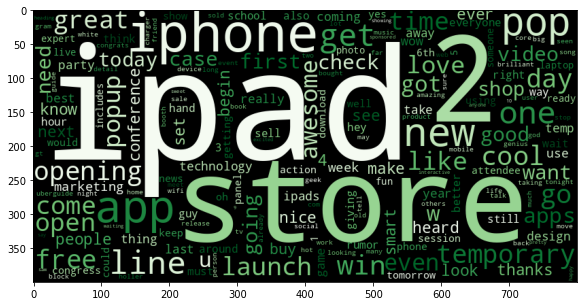

In [16]:
wordcloud = WordCloud(background_color='black',
                     colormap='Greens',
                     width=800,
                     height=400)

wordcloud.generate_from_frequencies(pos_apple_freqdist)
wordcloud.to_file('images/pos_apple_cloud.jpg')

plt.figure(figsize=(10,5))
plt.imshow(wordcloud);

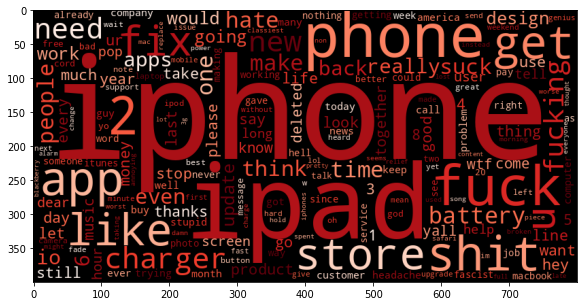

In [17]:
wordcloud = WordCloud(background_color='black',
                     colormap='Reds',
                     width=800,
                     height=400)

wordcloud.generate_from_frequencies(neg_apple_freqdist)
wordcloud.to_file('images/neg_apple_cloud.jpg')

plt.figure(figsize=(10,5))
plt.imshow(wordcloud);

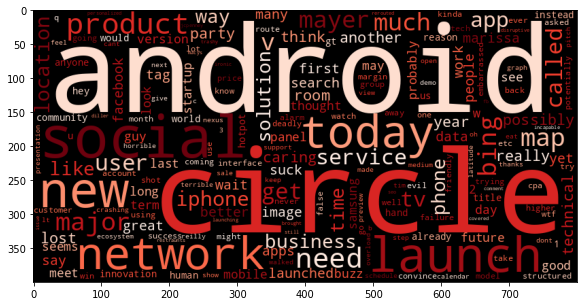

In [18]:
wordcloud = WordCloud(background_color='black',
                     colormap='Reds',
                     width=800,
                     height=400)

wordcloud.generate_from_frequencies(neg_google_freqdist)
wordcloud.to_file('images/neg_google_cloud.jpg')

plt.figure(figsize=(10,5))
plt.imshow(wordcloud);

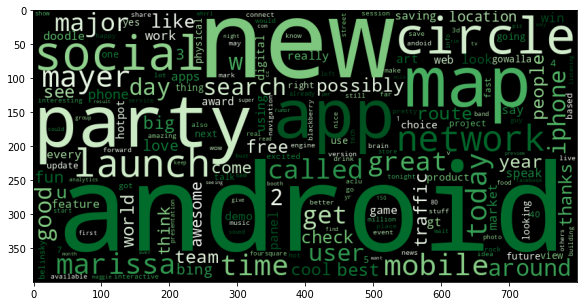

In [19]:
wordcloud = WordCloud(background_color='black',
                     colormap='Greens',
                     width=800,
                     height=400)

wordcloud.generate_from_frequencies(pos_google_freqdist)
wordcloud.to_file('images/pos_google_cloud.jpg')

plt.figure(figsize=(10,5))
plt.imshow(wordcloud);

In [20]:
bigram_measures = nltk.collocations.BigramAssocMeasures()
apple_neg_finder = BigramCollocationFinder.from_words(neg_apple_tokens)
apple_neg_scored = apple_neg_finder.score_ngrams(bigram_measures.raw_freq)
display(apple_neg_scored[:50])


neg_apple_pmi_finder = BigramCollocationFinder.from_words(neg_apple_tokens)
neg_apple_pmi_finder.apply_freq_filter(5)
neg_apple_pmi_scored = neg_apple_pmi_finder.score_ngrams(bigram_measures.pmi)
display(neg_apple_pmi_scored)

[(('ipad', '2'), 0.007190959936080356),
 (('iphone', '6'), 0.0025111288665677434),
 (('iphone', 'app'), 0.002282844424152494),
 (('io', '8'), 0.0020545599817372445),
 (('ipad', 'design'), 0.0020545599817372445),
 (('design', 'headache'), 0.0018262755393219953),
 (('shit', 'together'), 0.0018262755393219953),
 (('company', 'america'), 0.0014838488756991211),
 (('fascist', 'company'), 0.0013697066544914964),
 (('app', 'store'), 0.0012555644332838717),
 (('iphone', 'battery'), 0.0012555644332838717),
 (('pop', 'store'), 0.0012555644332838717),
 (('get', 'shit'), 0.001141422212076247),
 (('fix', 'shit'), 0.0010272799908686223),
 (('fuck', 'u'), 0.0010272799908686223),
 (('new', 'iphone'), 0.0010272799908686223),
 (('2', 'money'), 0.0009131377696609977),
 (('battery', 'life'), 0.0009131377696609977),
 (('best', 'thing'), 0.0009131377696609977),
 (('classiest', 'fascist'), 0.0009131377696609977),
 (('gave', 'ipad'), 0.0009131377696609977),
 (('look', 'like'), 0.0009131377696609977),
 (('piec

[(('barry', 'diller'), 10.511917335582625),
 (('kara', 'swisher'), 10.096879836303781),
 (('fast', 'among'), 9.77495174141642),
 (('among', 'digital'), 9.611453009133538),
 (('digital', 'delegate'), 9.611453009133538),
 (('fade', 'fast'), 9.260378568586662),
 (('steve', 'job'), 9.203795040220296),
 (('classiest', 'fascist'), 9.119599912803864),
 (('heard', 'weekend'), 9.037986147250212),
 (('elegant', 'fascist'), 8.804098087075934),
 (('company', 'america'), 8.802966117586013),
 (('fascist', 'company'), 8.787024573716995),
 (('macbook', 'pro'), 8.718368213050052),
 (('power', 'cord'), 8.663920429027673),
 (('weekend', 'gave'), 8.552559320079972),
 (('money', 'relief'), 8.380672802304375),
 (('design', 'headache'), 8.289524914246178),
 (('thing', 'heard'), 8.131095551641694),
 (('best', 'thing'), 7.993592027891758),
 (('customer', 'service'), 7.981402618883845),
 (('io', '8'), 7.708384124477428),
 (('relief', 'need'), 7.542290984626144),
 (('news', 'apps'), 7.139363167625296),
 (('piece

In [21]:
neg_apple_pmi_finder = BigramCollocationFinder.from_words(neg_apple_tokens)
neg_apple_pmi_finder.apply_freq_filter(5)
neg_apple_pmi_scored = neg_apple_pmi_finder.score_ngrams(bigram_measures.pmi)
display(neg_apple_pmi_scored)

[(('barry', 'diller'), 10.511917335582625),
 (('kara', 'swisher'), 10.096879836303781),
 (('fast', 'among'), 9.77495174141642),
 (('among', 'digital'), 9.611453009133538),
 (('digital', 'delegate'), 9.611453009133538),
 (('fade', 'fast'), 9.260378568586662),
 (('steve', 'job'), 9.203795040220296),
 (('classiest', 'fascist'), 9.119599912803864),
 (('heard', 'weekend'), 9.037986147250212),
 (('elegant', 'fascist'), 8.804098087075934),
 (('company', 'america'), 8.802966117586013),
 (('fascist', 'company'), 8.787024573716995),
 (('macbook', 'pro'), 8.718368213050052),
 (('power', 'cord'), 8.663920429027673),
 (('weekend', 'gave'), 8.552559320079972),
 (('money', 'relief'), 8.380672802304375),
 (('design', 'headache'), 8.289524914246178),
 (('thing', 'heard'), 8.131095551641694),
 (('best', 'thing'), 7.993592027891758),
 (('customer', 'service'), 7.981402618883845),
 (('io', '8'), 7.708384124477428),
 (('relief', 'need'), 7.542290984626144),
 (('news', 'apps'), 7.139363167625296),
 (('piece

In [22]:
neg_apple_pmi_finder = TrigramCollocationFinder.from_words(neg_apple_tokens)
neg_apple_pmi_finder.apply_freq_filter(4)
neg_apple_pmi_scored = neg_apple_pmi_finder.score_ngrams(trigram_measures.pmi)
display(neg_apple_pmi_scored)

[(('heat', 'million', 'sun'), 21.286869076999047),
 (('button', 'heat', 'million'), 20.412399959082904),
 (('among', 'digital', 'delegate'), 19.900977923379717),
 (('fade', 'fast', 'among'), 19.549903482832836),
 (('fast', 'among', 'digital'), 19.386404750549957),
 (('heard', 'weekend', 'gave'), 18.32751106149639),
 (('classiest', 'fascist', 'company'), 18.129016907857306),
 (('back', 'button', 'heat'), 17.876347058842697),
 (('fascist', 'company', 'america'), 17.851482932328395),
 (('best', 'thing', 'heard'), 17.76854376930818),
 (('thing', 'heard', 'weekend'), 17.49100979377927),
 (('apps', 'fade', 'fast'), 16.69192248770527),
 (('news', 'apps', 'fade'), 16.106959986984112),
 (('money', 'relief', 'need'), 15.922963786930515),
 (('2', 'money', 'relief'), 15.001819207641754),
 (('weekend', 'gave', 'ipad'), 14.072010328348005),
 (('novelty', 'ipad', 'news'), 13.902085326905693),
 (('ipad', 'design', 'headache'), 13.715866518122727),
 (('relief', 'need', 'ipad'), 12.869096914951779),
 ((

In [23]:
neg_apple_pmi_finder = QuadgramCollocationFinder.from_words(neg_apple_tokens)
neg_apple_pmi_finder.apply_freq_filter(3)
neg_apple_pmi_scored = neg_apple_pmi_finder.score_ngrams(fourgram_measures.pmi)
display(neg_apple_pmi_scored)

[(('minor', 'improvement', 'worth', 'unless'), 33.79878641258167),
 (('forward', 'delicious', 'mobile', '4g'), 32.06182081841546),
 (('button', 'heat', 'million', 'sun'), 30.92431729466553),
 (('fast', 'among', 'digital', 'delegate'), 29.67592966479613),
 (('truly', 'displeased', 'customer', 'service'), 29.590199790770253),
 (('displeased', 'customer', 'service', 'given'), 29.268271695882888),
 (('fade', 'fast', 'among', 'digital'), 29.161356491966373),
 (('2', 'minor', 'improvement', 'worth'), 28.90801548233643),
 (('back', 'button', 'heat', 'million'), 28.651298800259113),
 (('recently', 'deleted', 'photo', 'album'), 28.342272277326664),
 (('news', 'fade', 'fast', 'among'), 27.517500302191657),
 (('novelty', 'news', 'fade', 'fast'), 27.517500302191657),
 (('best', 'thing', 'heard', 'weekend'), 27.12845801144575),
 (('classiest', 'fascist', 'company', 'america'), 27.126361070610177),
 (('company', 'america', 'kara', 'swisher'), 27.073893650716037),
 (('apps', 'fade', 'fast', 'among'),

### Data Exploration By Brand

Below are some quick examinations of the distribution of tweets by brand and sentiment.

After being seperated by brand/emotion pairs, the twitter text data will be processed and cleaned. The text data will then be tokenized using a scikit learn Twitter tokenizer before creating term frequency counts for each brand/emotion combination using the tokenized text data. The term frequency counts are used to generate word clouds to quickly visualize what people do and do not like about the brand or product. Bigrams, trigrams, and quadrgrams were created using [Pointwise Mutual Information(PMI)](https://en.wikipedia.org/wiki/Pointwise_mutual_information) scores generated using NLTK collocations.

Pointwise mutual information can be used to determine if two words co-occur by chance or have a high probability to express a unique concept. This concept can be expanded to determine if three words have a high probability to occur together, four and so on.

These Natural Language Processing (NLP) techniques and others can easily be used to make actionable insight from twitter data.



#### Some observations from exploring the data:

- Multiple complaints about issues with iphone 6 and its new touch id feature. Some googling unveiled an issue in which iphone 6 touch id button / home button would malfunction and heat up to high temperatures.

- many complaints about phone chargers 

- high negative sentiment for iphone batteries 

- Some users displeased with issues with apple news app

- apple ipad 2 described as a design headache

- Complaints about customer service

- public image described as fascist 


Recommend to focus on improving battery life and quality. Improve phone accessories for charging and protecting batteries. (apple did improved a lot on this since 2011 when many of the tweets were collected)

Address technical issues with iphone 6 and apple news app crashing.

Launch a public relations campaign and give back to the community to boost public image.

Reassess training protocols for customer facing employees and ensure customer service is a cornerstone of Apple culture.



#### Proof of Concept
Actionable insight can be gained with enough social media data. A reasonable amount of labeled data can be budgeted for a growing business in order to train a machine learning sentiment classifier on that data and deploy it in order to gain more insights into consumer sentiment on your brand or products. 


This is the end of this notebook. Please feel free to continue on to the modeling notebook to see how a classifier could be trained and tuned.

Feel free to reach out with corrections or questions. Thank you.

Author: Dylan Dey

email: ddey2985@gmail.com

